I) Manipulation de la Donnée


In [61]:
# Décompression du dataset
!unzip malaria_hematie_dataset.zip -d malaria_hematie_dataset/

Archive:  malaria_hematie_dataset.zip
replace malaria_hematie_dataset/malaria_hematie_dataset/parasitized/image_10000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pdy
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [3]:
# Fonction pour charger et prétraiter les images
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def load_dataset(dataset_path, img_size=64):
    images, labels = [], []
    for label, category in enumerate(['parasitized', 'uninfected']):
        for file in os.listdir(os.path.join(dataset_path, category)):
            img = load_img(os.path.join(dataset_path, category, file), target_size=(img_size, img_size)) # Chargement et redimensionnement
            images.append(img_to_array(img))  # Conversion en tableau
            labels.append(label)   # Attribution du label
    return np.array(images), np.array(labels)

# Chargement des données
dataset_path = "malaria_hematie_dataset/malaria_hematie_dataset/"
images, labels = load_dataset(dataset_path)

In [4]:
# Encodage des labels

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels).astype('float32')

In [5]:
# Séparation en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalisation des pixels dans l'intervalle [0,1]
    rotation_range=20,      # Rotation aléatoire des images jusqu'à ±20 degrés
    width_shift_range=0.2,  # Décalage horizontal aléatoire jusqu'à 20% de la largeur de l'image
    height_shift_range=0.2, # Décalage vertical aléatoire jusqu'à 20% de la hauteur de l'image
    shear_range=0.2,        # Transformation affine en cisaillement jusqu'à 20%
    zoom_range=0.2,         # Zoom avant/arrière aléatoire jusqu'à 20%
    horizontal_flip=True    # Inversion horizontale aléatoire des images
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

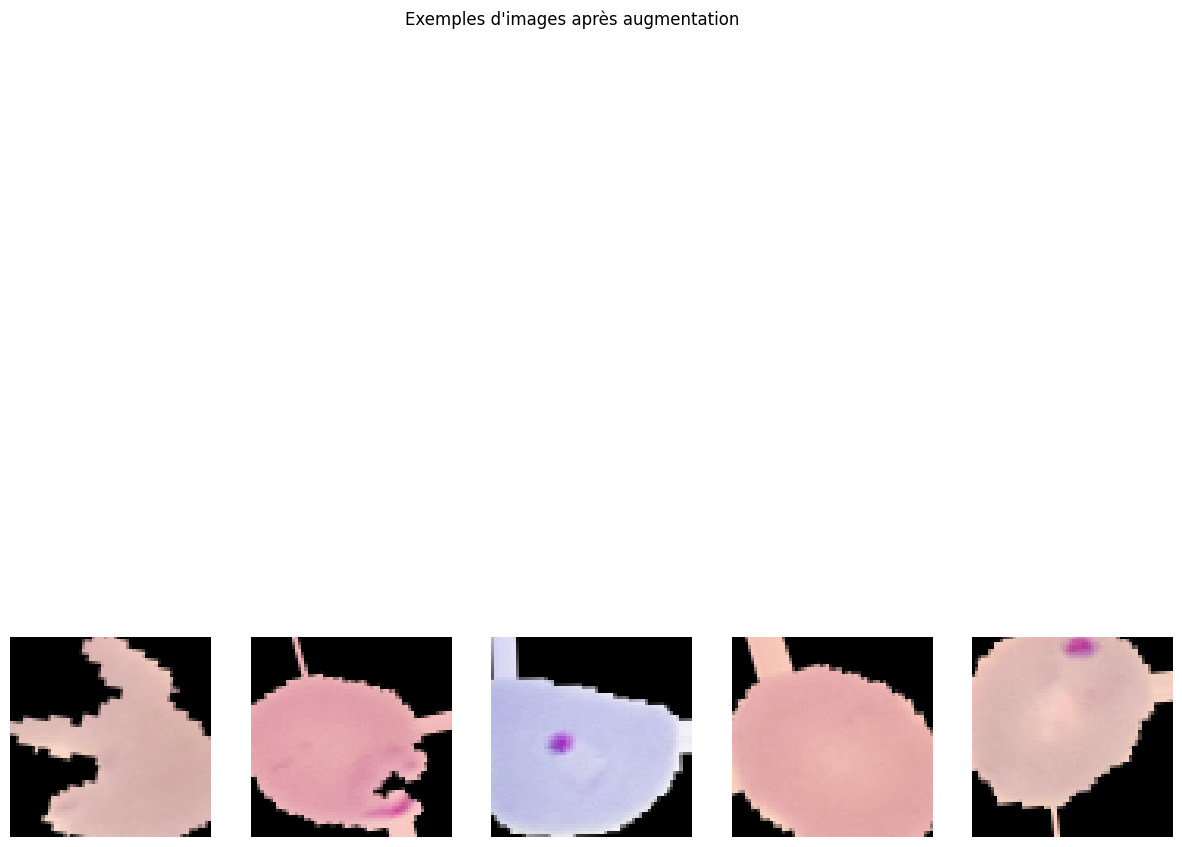

In [7]:
import matplotlib.pyplot as plt

# Appliquer la Data Augmentation sur les images
train_datagen.fit(X_train)

# Générer un batch d'images augmentées
augmented_images = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

# Afficher quelques exemples d'images augmentées
fig, axes = plt.subplots(1, 5, figsize=(15, 15))

for i, ax in enumerate(axes):
    ax.imshow(augmented_images[0][0][i])  # Première batch, première dimension = images
    ax.axis('off')  # Cacher les axes

plt.suptitle("Exemples d'images après augmentation")
plt.show()


II) Entraînement de 3 Modèles


In [59]:
# Arrêter l'entraînement si la perte de validation ne s'améliore pas après 7 époques
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
# Réduire le taux d'apprentissage si la perte de validation stagne après 3 époques
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3, min_lr=1e-6)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf

# Création du modèle CNN amélioré
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform',  input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Optimiseur avec learning rate ajustable
initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Compilation du modèle
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Affichage du résumé du modèle
model_cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 652,993 (2.49 MB)

 Trainable params: 652,033 (2.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [10]:
# model_cnn pour entraîner le modèl
from sklearn.model_selection import train_test_split
history_cnn = model_cnn.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_decay]
)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 60ms/step - accuracy: 0.6419 - loss: 0.7397 - val_accuracy: 0.8019 - val_loss: 0.5287 - learning_rate: 0.0010
Epoch 2/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.8687 - loss: 0.3213 - val_accuracy: 0.9421 - val_loss: 0.2101 - learning_rate: 0.0010
Epoch 3/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 35s 50ms/step - accuracy: 0.9045 - loss: 0.2643 - val_accuracy: 0.9516 - val_loss: 0.1566 - learning_rate: 0.0010
Epoch 4/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - accuracy: 0.9170 - loss: 0.2375 - val_accuracy: 0.9516 - val_loss: 0.1737 - learning_rate: 0.0010
Epoch 5/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.9229 - loss: 0.2321 - val_accuracy: 0.9568 - val_loss: 0.1468 - learning_rate: 0.0010
Epoch 6/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.9214 - loss: 0.2248 - val_accuracy: 0.9588 - val_loss: 0.1379 - learning_rate: 0.0010
Epoch 7/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - accuracy: 0.9186 - loss: 

In [57]:
# Sauvegarder le modèle entraîné
model_cnn.save("model_cnn_improved.h5")

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prédictions sur les données de validation
y_pred_prob = model_cnn.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Binarisation

# Calcul des métriques
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Matrice de confusion
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
sensibilite = recall  # Sensibilité = Recall (TPR)
specificite = tn / (tn + fp)  # Spécificité = TN / (TN + FP)

# Affichage des résultats
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensibilité): {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Spécificité: {specificite:.4f}")


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.7930
Precision: 0.7054
Recall (Sensibilité): 0.9956
F1-score: 0.8257
Spécificité: 0.5964


In [26]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Charger VGG16 avec des poids pré-entraînés et sans la couche de classification finale
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Débloquer les 10 dernières couches pour un apprentissage plus spécifique
for layer in vgg16.layers[-10:]:
    layer.trainable = True

# Construction du modèle
model_vgg16 = Sequential([
    vgg16,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle avec un optimiseur adapté
optimizer = Adam(learning_rate=0.0001)
model_vgg16.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model_vgg16.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,108,929 (57.64 MB)

 Trainable params: 15,108,929 (57.64 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:

# Entraîner le modèle avec augmentation de données
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_decay]
)

# Sauvegarder le modèle entraîné
model_vgg16.save("model_vgg16_improved.h5")

Epoch 1/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 71s 92ms/step - accuracy: 0.8873 - loss: 0.2813 - val_accuracy: 0.9630 - val_loss: 0.1272 - learning_rate: 1.0000e-04
Epoch 2/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.9373 - loss: 0.1831 - val_accuracy: 0.9641 - val_loss: 0.1167 - learning_rate: 1.0000e-04
Epoch 3/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 78ms/step - accuracy: 0.9439 - loss: 0.1572 - val_accuracy: 0.9648 - val_loss: 0.1109 - learning_rate: 1.0000e-04
Epoch 4/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.9449 - loss: 0.1519 - val_accuracy: 0.9686 - val_loss: 0.0977 - learning_rate: 1.0000e-04
Epoch 5/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - accuracy: 0.9493 - loss: 0.1421 - val_accuracy: 0.9681 - val_loss: 0.1160 - learning_rate: 1.0000e-04
Epoch 6/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.9486 - loss: 0.1427 - val_accuracy: 0.9690 - val_loss: 0.0950 - learning_rate: 1.0000e-04
Epoch 7/200
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 7

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Prédictions sur les données de validation
y_pred_prob = model_vgg16.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype("int32")  # Binarisation

# Calcul des métriques
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Matrice de confusion
tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
sensibilite = recall  # Sensibilité = Recall (TPR)
specificite = tn / (tn + fp)  # Spécificité = TN / (TN + FP)

# Affichage des résultats
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensibilité): {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Spécificité: {specificite:.4f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Accuracy: 0.9198
Precision: 0.9805
Recall (Sensibilité): 0.8541
F1-score: 0.9130
Spécificité: 0.9836


In [32]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Charger ResNet50 avec des poids pré-entraînés et sans la couche de classification finale
resnet50 = ResNet50(weights=None, include_top=False, input_shape=(64, 64, 3))

# Débloquer les 10 dernières couches pour un apprentissage plus spécifique
for layer in resnet50.layers[-10:]:
    layer.trainable = True

# Construction du modèle
model_resnet50 = Sequential([
    resnet50,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilation du modèle avec un optimiseur adapté
optimizer = Adam(learning_rate=0.0001)
model_resnet50.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Afficher le résumé du modèle
model_resnet50.summary()



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2, 2, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,768,385 (94.48 MB)

 Trainable params: 24,715,265 (94.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [33]:

# Entraîner le modèle avec augmentation de données
history_resnet50 = model_resnet50.fit(
    train_generator,
    epochs=150,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_decay]
)




Epoch 1/150
689/689 ━━━━━━━━━━━━━━━━━━━━ 143s 123ms/step - accuracy: 0.5519 - loss: 0.7335 - val_accuracy: 0.6067 - val_loss: 0.7058 - learning_rate: 1.0000e-04
Epoch 2/150
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 75ms/step - accuracy: 0.6795 - loss: 0.6091 - val_accuracy: 0.6618 - val_loss: 0.7242 - learning_rate: 1.0000e-04
Epoch 3/150
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.7687 - loss: 0.4844 - val_accuracy: 0.7014 - val_loss: 0.9690 - learning_rate: 1.0000e-04
Epoch 4/150
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.8457 - loss: 0.3602 - val_accuracy: 0.5521 - val_loss: 1.7108 - learning_rate: 1.0000e-04
Epoch 5/150
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 73ms/step - accuracy: 0.8852 - loss: 0.2922 - val_accuracy: 0.5074 - val_loss: 3.9777 - learning_rate: 9.5000e-05
Epoch 6/150
689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 74ms/step - accuracy: 0.9019 - loss: 0.2596 - val_accuracy: 0.9204 - val_loss: 0.2428 - learning_rate: 9.5000e-05
Epoch 7/150
689/689 ━━━━━━━━━━━━━━━━━━━━ 50s

In [53]:
# Sauvegarder le modèle entraîné
model_resnet50.save("model_resnet50_improved.h5")

173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

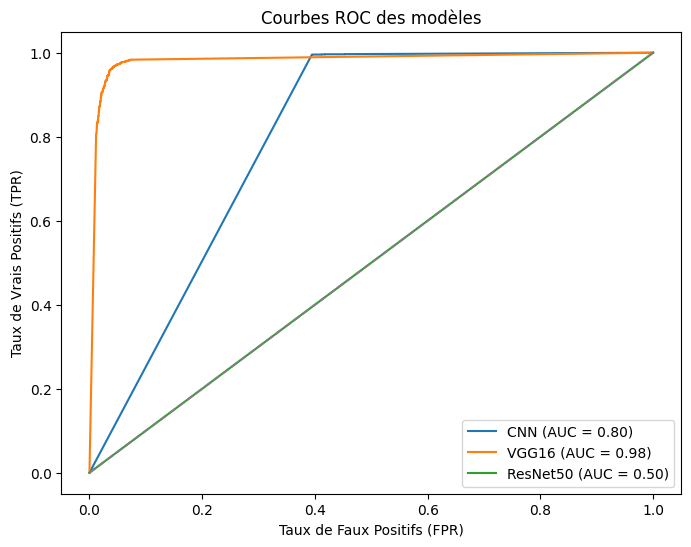

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Liste des modèles et leurs noms
models = {
    "CNN": model_cnn,
    "VGG16": model_vgg16,
    "ResNet50": model_resnet50
}

plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    # Prédictions des probabilités sur les données de validation
    y_pred_proba = model.predict(X_val).ravel()

    # Calcul des courbes ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Ajouter la diagonale aléatoire
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Personnalisation du graphique
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbes ROC des modèles")
plt.legend()
plt


Test des Modèles



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


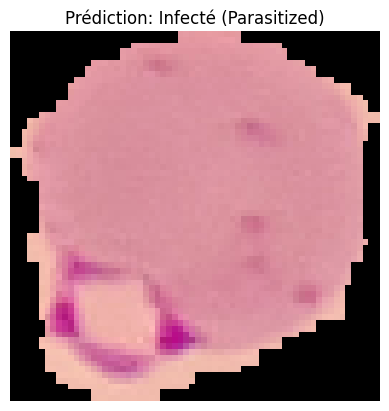

Résultat: Infecté (Parasitized)


In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Charger le modèle
model = tf.keras.models.load_model("model_vgg16_improved.h5")

# Fonction de prédiction sur une image
def predict_image(img_path, model):
    # Charger l'image et la prétraiter
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisation

    # Faire la prédiction
    prediction = model.predict(img_array)

    # Convertir en classe (0: Parasitized, 1: Uninfected)
    class_name = "Infecté (Parasitized)" if prediction < 0.5 else "Sain (Uninfected)"

    # Afficher l'image et la prédiction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prédiction: {class_name}")
    plt.show()

    return class_name

# Tester avec une image
image_path = "malaria_hematie_dataset/malaria_hematie_dataset/parasitized/image_5.png"
result = predict_image(image_path, model)
print("Résultat:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


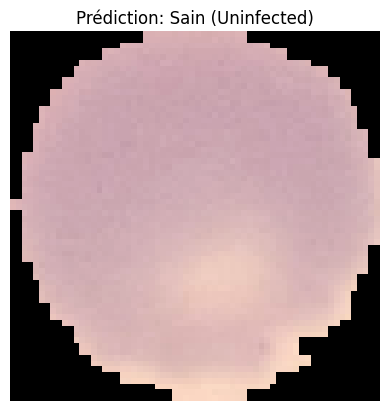

Résultat: Sain (Uninfected)


In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Charger le modèle
model = tf.keras.models.load_model("model_vgg16_improved.h5")

# Fonction de prédiction sur une image
def predict_image(img_path, model):
    # Charger l'image et la prétraiter
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisation

    # Faire la prédiction
    prediction = model.predict(img_array)

    # Convertir en classe (0: Parasitized, 1: Uninfected)
    class_name = "Infecté (Parasitized)" if prediction < 0.5 else "Sain (Uninfected)"

    # Afficher l'image et la prédiction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prédiction: {class_name}")
    plt.show()

    return class_name

# Tester avec une image
image_path = "malaria_hematie_dataset/malaria_hematie_dataset/uninfected/image_4.png"
result = predict_image(image_path, model)
print("Résultat:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


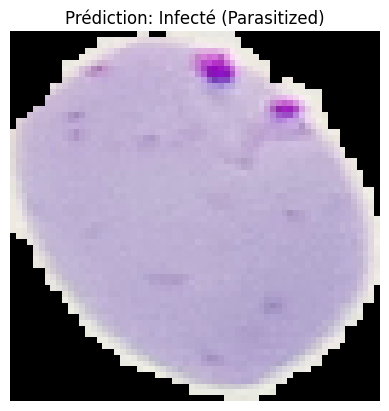

Résultat: Infecté (Parasitized)


In [56]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Charger le modèle
model = tf.keras.models.load_model("model_resnet50_improved.h5")

# Fonction de prédiction sur une image
def predict_image(img_path, model):
    # Charger l'image et la prétraiter
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisation

    # Faire la prédiction
    prediction = model.predict(img_array)

    # Convertir en classe (0: Parasitized, 1: Uninfected)
    class_name = "Infecté (Parasitized)" if prediction < 0.5 else "Sain (Uninfected)"

    # Afficher l'image et la prédiction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prédiction: {class_name}")
    plt.show()

    return class_name

# Tester avec une image
image_path = "malaria_hematie_dataset/malaria_hematie_dataset/parasitized/image_21.png"
result = predict_image(image_path, model)
print("Résultat:", result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step


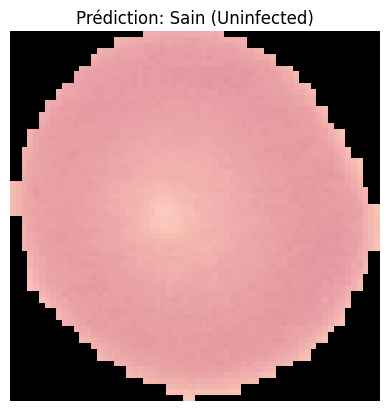

Résultat: Sain (Uninfected)


In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Charger le modèle (remplace par ton modèle entraîné)
model = tf.keras.models.load_model("model_cnn_improved.h5")

# Fonction de prédiction sur une image
def predict_image(img_path, model):
    # Charger l'image et la prétraiter
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalisation

    # Faire la prédiction
    prediction = model.predict(img_array)

    # Convertir en classe (0: Parasitized, 1: Uninfected)
    class_name = "Infecté (Parasitized)" if prediction < 0.5 else "Sain (Uninfected)"

    # Afficher l'image et la prédiction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prédiction: {class_name}")
    plt.show()

    return class_name

# Tester avec une image
image_path = "malaria_hematie_dataset/malaria_hematie_dataset/uninfected/image_17.png"
result = predict_image(image_path, model)
print("Résultat:", result)